# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import liesel_gam as gam
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

from smoothcon import SmoothFactory

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

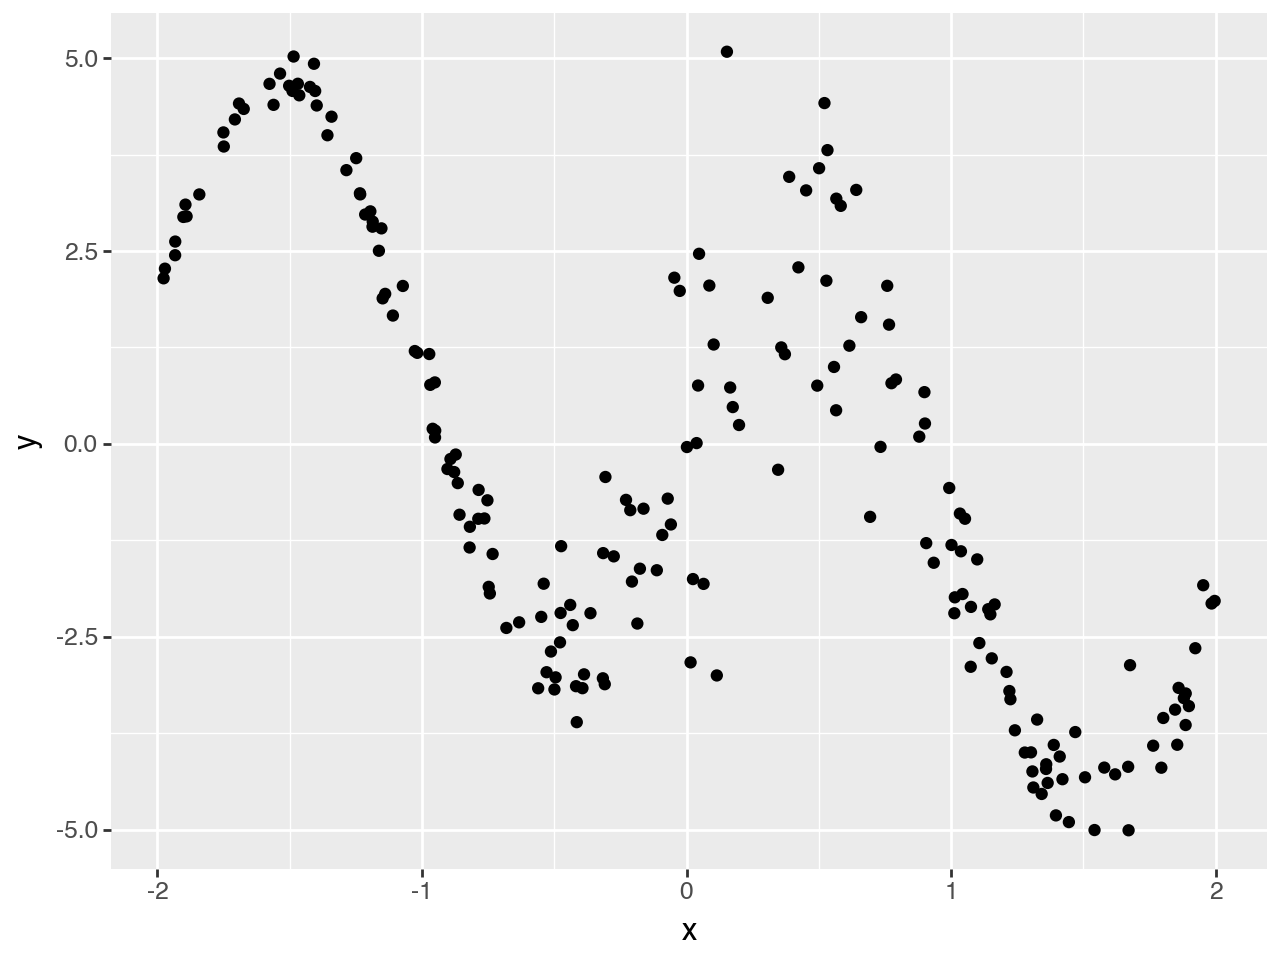

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

The `gam.AdditivePredictor()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [4]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=y,
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

### Set up intercepts

In [5]:
loc += gam.Intercept(name="$\\beta_0$", inference=gs.MCMCSpec(gs.IWLSKernel))
scale += gam.Intercept(name="$\\gamma_0$", inference=gs.MCMCSpec(gs.IWLSKernel))

### Set up basis and penalty matrices

Here, we pull the basis matrix and penalty from mgcv. Note that, using the 
`SmoothCon` class, you only need to execute Python code. No manual R call and 
convesion to Python objects necessary.

In [6]:
sf = SmoothFactory(df)
smooth_x = sf("s(x, bs='ps', k=20)")

xvar = lsl.Var.new_obs(x, name="x")
x_basis = gam.Basis(value=xvar, basis_fn=smooth_x)

### Initialize smooth terms

The `gam.SmoothTerm` can be used to represent isotropic smooths. It is a `lsl.Var` that
will automatically initialize a fitting coefficient variable with a 
potentially singular multivariate normal prior given the penalty matrix.

In [7]:
loc += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=smooth_x.penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="m(x)",
    variance_name="$\\tau^2_m$",
    coef_name="$\\beta$",  # I'm using LaTeX math syntax for pretty rendering in plots
)

scale += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=smooth_x.penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="s(x)",
    variance_name="$\\tau^2_s$",
    coef_name="$\\gamma$",
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="x_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


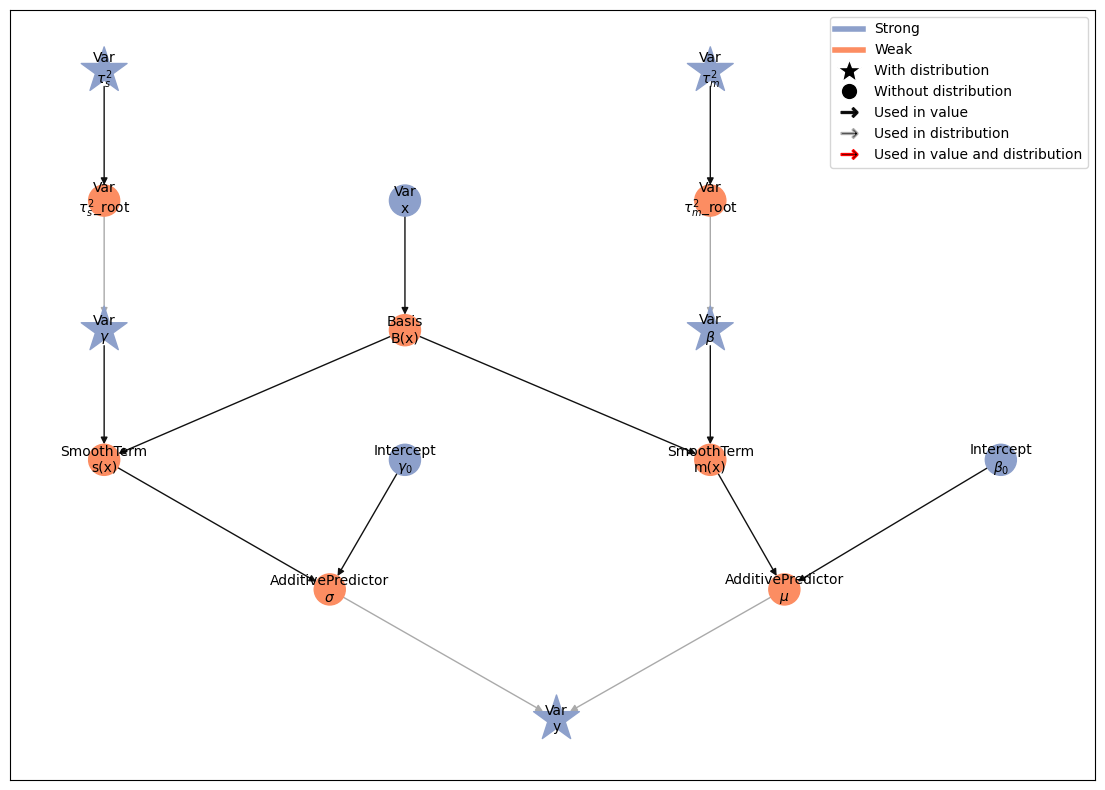

In [8]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [9]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\gamma$', '$\\tau^2_s$', '$\\gamma_0$', '$\\beta$', '$\\tau^2_m$', '$\\beta_0$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  5.80chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 148.57chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 164.24chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - S

### MCMC summary

In [10]:
summary = gs.Summary(results)
summary

Parameter summary:

                     kernel      mean        sd    q_0.05     q_0.5    q_0.95  \
parameter  index                                                                
$\beta$    (0,)   kernel_03  0.170820  0.365636 -0.407132  0.162275  0.775898   
           (1,)   kernel_03 -0.156378  0.327957 -0.705422 -0.144948  0.361286   
           (2,)   kernel_03  0.150995  0.325829 -0.370651  0.146368  0.700467   
           (3,)   kernel_03  0.153216  0.312175 -0.358357  0.149189  0.663054   
           (4,)   kernel_03  0.283811  0.305738 -0.202615  0.268507  0.814082   
           (5,)   kernel_03  0.006351  0.279030 -0.454455  0.005512  0.467582   
           (6,)   kernel_03 -0.020087  0.263457 -0.452660 -0.021089  0.412676   
           (7,)   kernel_03 -0.116587  0.234694 -0.496144 -0.116677  0.270326   
           (8,)   kernel_03  0.074690  0.232895 -0.286368  0.068827  0.467174   
           (9,)   kernel_03  0.087738  0.188139 -0.220760  0.085445  0.400884   
           (10,)  kernel_03  0.062108  0.178869 -0.229945  0.066173  0.349773   
           (11,)  kernel_03 -0.060295  0.142644 -0.287740 -0.060402  0.172852   
           (12,)  kernel_03  0.064363  0.120780 -0.128550  0.064518  0.261503   
           (13,)  kernel_03 -0.075219  0.089978 -0.220911 -0.074693  0.073310   
           (14,)  kernel_03  1.241541  0.067795  1.132032  1.240230  1.352030   
           (15,)  kernel_03 -0.029793  0.043144 -0.099061 -0.029776  0.041403   
           (16,)  kernel_03 -0.017775  0.022827 -0.054817 -0.018082  0.020248   
           (17,)  kernel_03  0.010487  0.009281 -0.004905  0.010642  0.025526   
           (18,)  kernel_03 -0.418758  0.033130 -0.472590 -0.418746 -0.365430   
$\beta_0$  ()     kernel_05 -0.317911  0.061503 -0.419654 -0.317045 -0.216319   
$\gamma$   (0,)   kernel_00  0.017941  0.110298 -0.151937  0.012756  0.200484   
           (1,)   kernel_00 -0.020368  0.107355 -0.198347 -0.016133  0.147169   
           (2,)   kernel_00 -0.011116  0.109083 -0.189047 -0.011128  0.162992   
           (3,)   kernel_00 -0.004028  0.104338 -0.174056 -0.003133  0.164021   
           (4,)   kernel_00 -0.005196  0.106389 -0.176675 -0.005495  0.165482   
           (5,)   kernel_00 -0.010175  0.106124 -0.185696 -0.009184  0.162378   
           (6,)   kernel_00 -0.051217  0.107535 -0.237450 -0.044765  0.111525   
           (7,)   kernel_00 -0.051028  0.102616 -0.227804 -0.042555  0.107380   
           (8,)   kernel_00  0.016119  0.095706 -0.135543  0.014537  0.170357   
           (9,)   kernel_00 -0.021114  0.092521 -0.177964 -0.019723  0.125475   
           (10,)  kernel_00  0.028173  0.087411 -0.108555  0.023474  0.173781   
           (11,)  kernel_00  0.017298  0.080378 -0.109445  0.015841  0.152488   
           (12,)  kernel_00  0.090298  0.073643 -0.024540  0.085383  0.218172   
           (13,)  kernel_00 -0.081391  0.061784 -0.184527 -0.079667  0.018080   
           (14,)  kernel_00  0.059770  0.047978 -0.017777  0.059011  0.140910   
           (15,)  kernel_00 -0.078250  0.032961 -0.133514 -0.077925 -0.025527   
           (16,)  kernel_00  0.007263  0.018853 -0.023442  0.006864  0.039161   
           (17,)  kernel_00 -0.042819  0.007894 -0.055377 -0.042745 -0.029103   
           (18,)  kernel_00  0.125369  0.030141  0.075880  0.125057  0.175426   
$\gamma_0$ ()     kernel_02 -0.630497  0.053182 -0.716616 -0.631093 -0.542222   
$\tau^2_m$ ()     kernel_04  0.168307  0.076506  0.082342  0.151325  0.323998   
$\tau^2_s$ ()     kernel_01  0.011846  0.008975  0.003777  0.009350  0.027881   

                  sample_size     ess_bulk     ess_tail      rhat  
parameter  index                                                   
$\beta$    (0,)          4000  3476.542443  3577.126288  1.000282  
           (1,)          4000  3336.931269  3702.504009  1.000447  
           (2,)          4000  3557.680362  3363.683979  1.000076  
           (3,)          4000  3424.333736  3766.157922  0.999895  
       

### MCMC trace plots

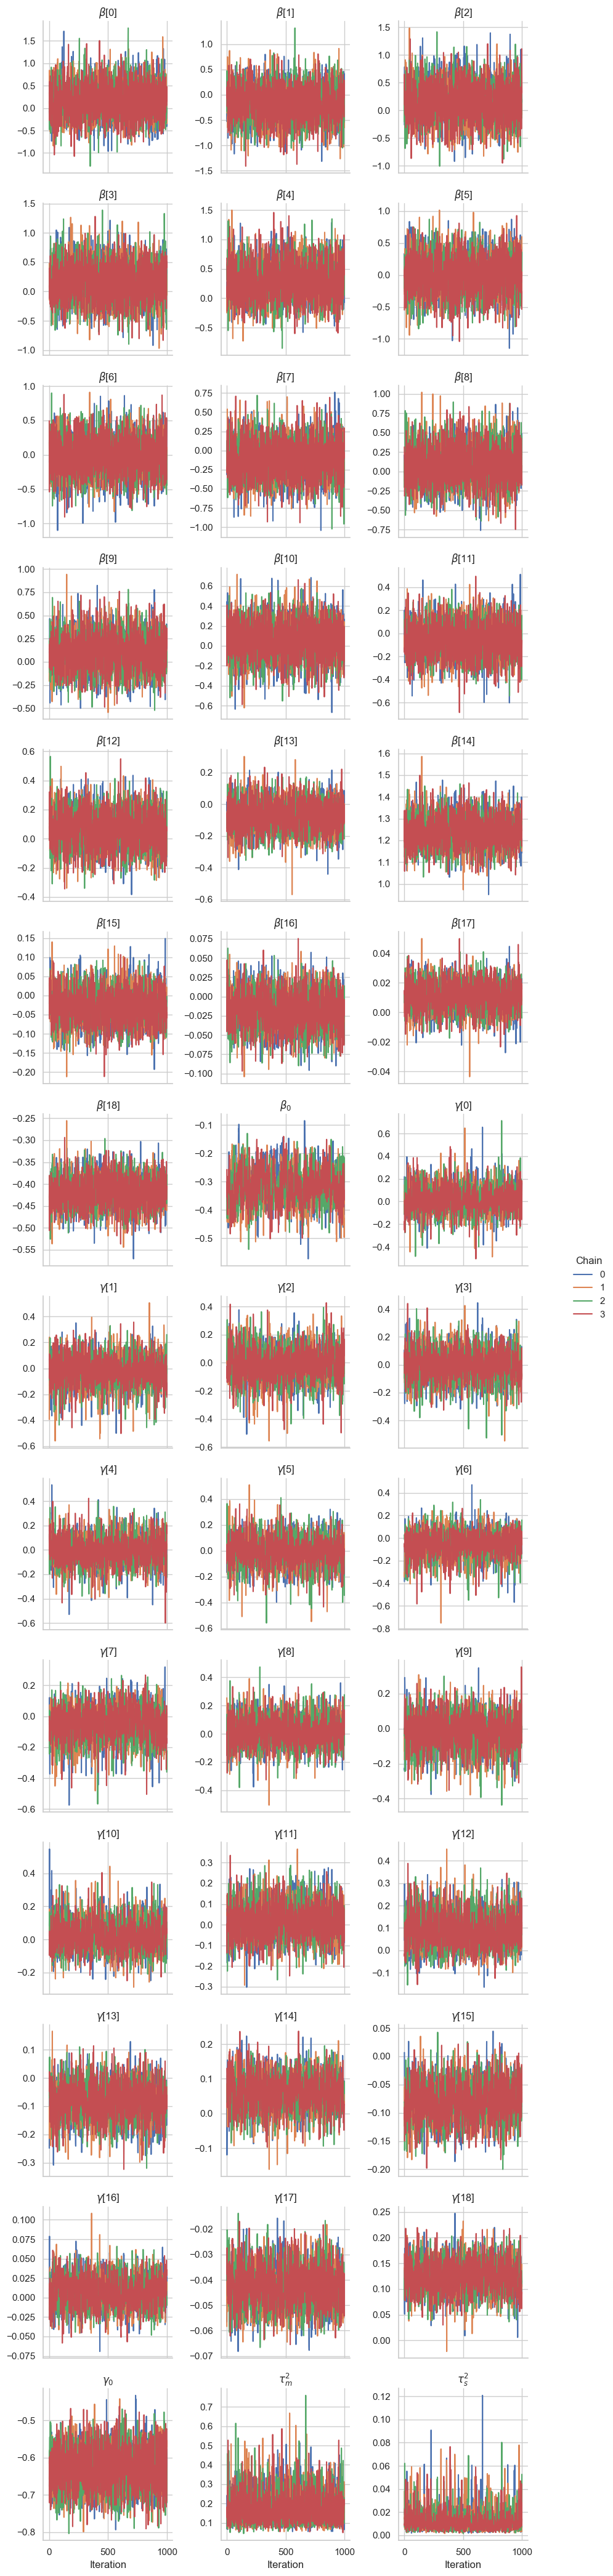

In [11]:
gs.plot_trace(results)

## Predictions

In [12]:
samples = results.get_posterior_samples()

### Evaluate basis matrix for new x values

We use the `SmoothCon` oject initialized above. This will internally call `mgcv`
to evaluate the basis matrix at the new x values, applying all the right reparameterizations 
automatically.

### Predict variables at new x values

In [13]:
x_grid = jnp.linspace(x.min(), x.max(), 200)

predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "s(x)", "$\\mu$", "$\\sigma$"],
    newdata={"x": x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [14]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.191582,0.004403,0.066353,0.999794,3411.996926,3769.512700,0.001136,0.000952,2.088289,2.189148,2.306517,2.091739,2.308181,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.378958,0.002436,0.049357,0.999595,3491.653068,3406.236883,0.000833,0.000759,2.302559,2.377957,2.461984,2.297965,2.456335,-1.956738
2,$\mu$,$\mu$[2],"(2,)",4000,2.560425,0.001772,0.042095,1.000467,3543.844777,3497.054965,0.000704,0.000652,2.493821,2.560458,2.628801,2.490930,2.624901,-1.936774
3,$\mu$,$\mu$[3],"(3,)",4000,2.735928,0.001715,0.041412,1.000058,3519.469516,3762.036861,0.000697,0.000615,2.668089,2.736824,2.802609,2.674139,2.807869,-1.916810
4,$\mu$,$\mu$[4],"(4,)",4000,2.905407,0.001874,0.043289,1.000122,3456.414839,3688.462217,0.000736,0.000620,2.832787,2.906718,2.973918,2.833682,2.974108,-1.896846


### Plot fitted functions

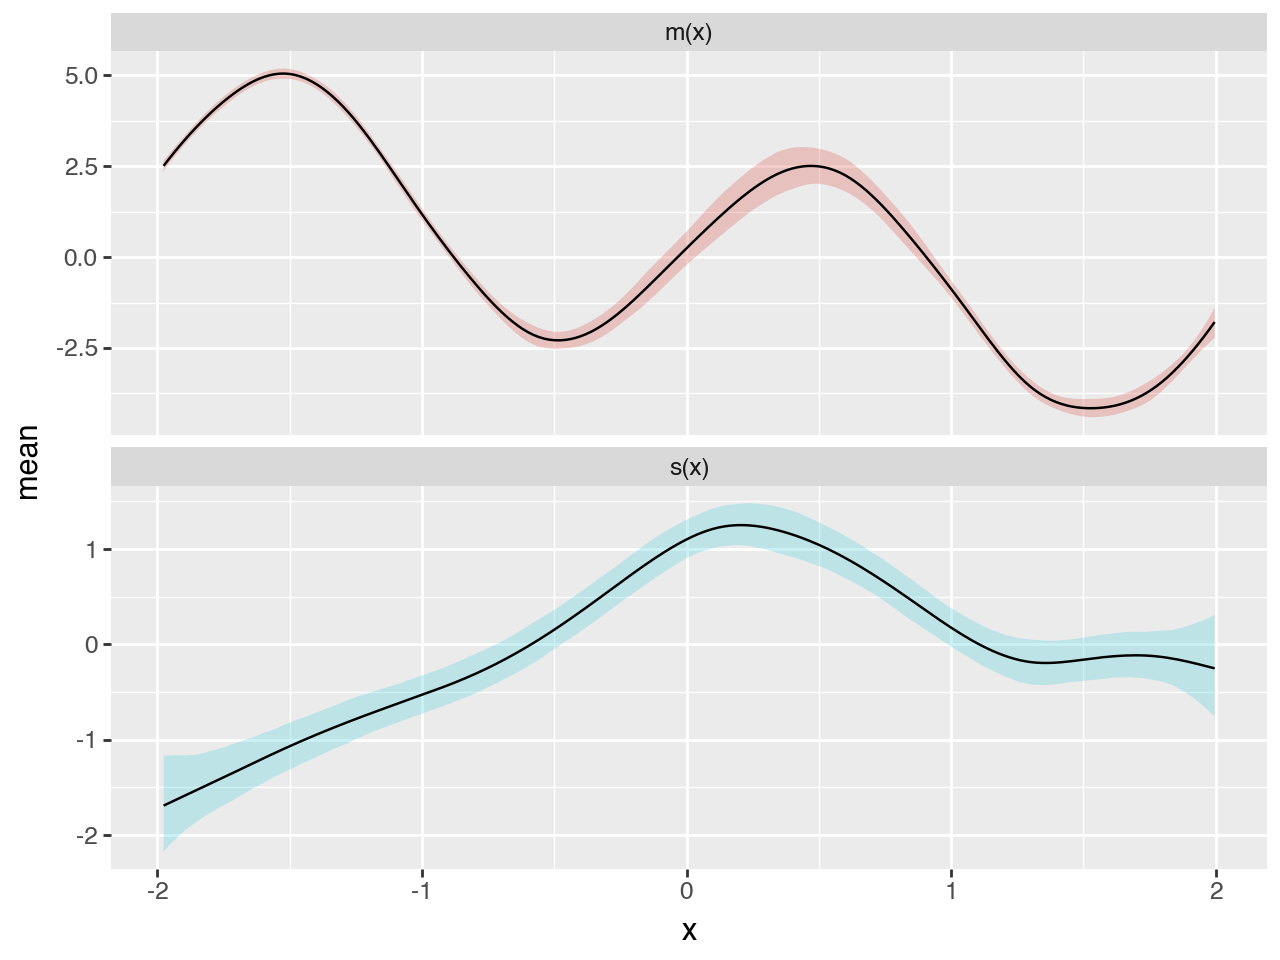

In [15]:
select = predictions_summary["variable"].isin(["s(x)", "m(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

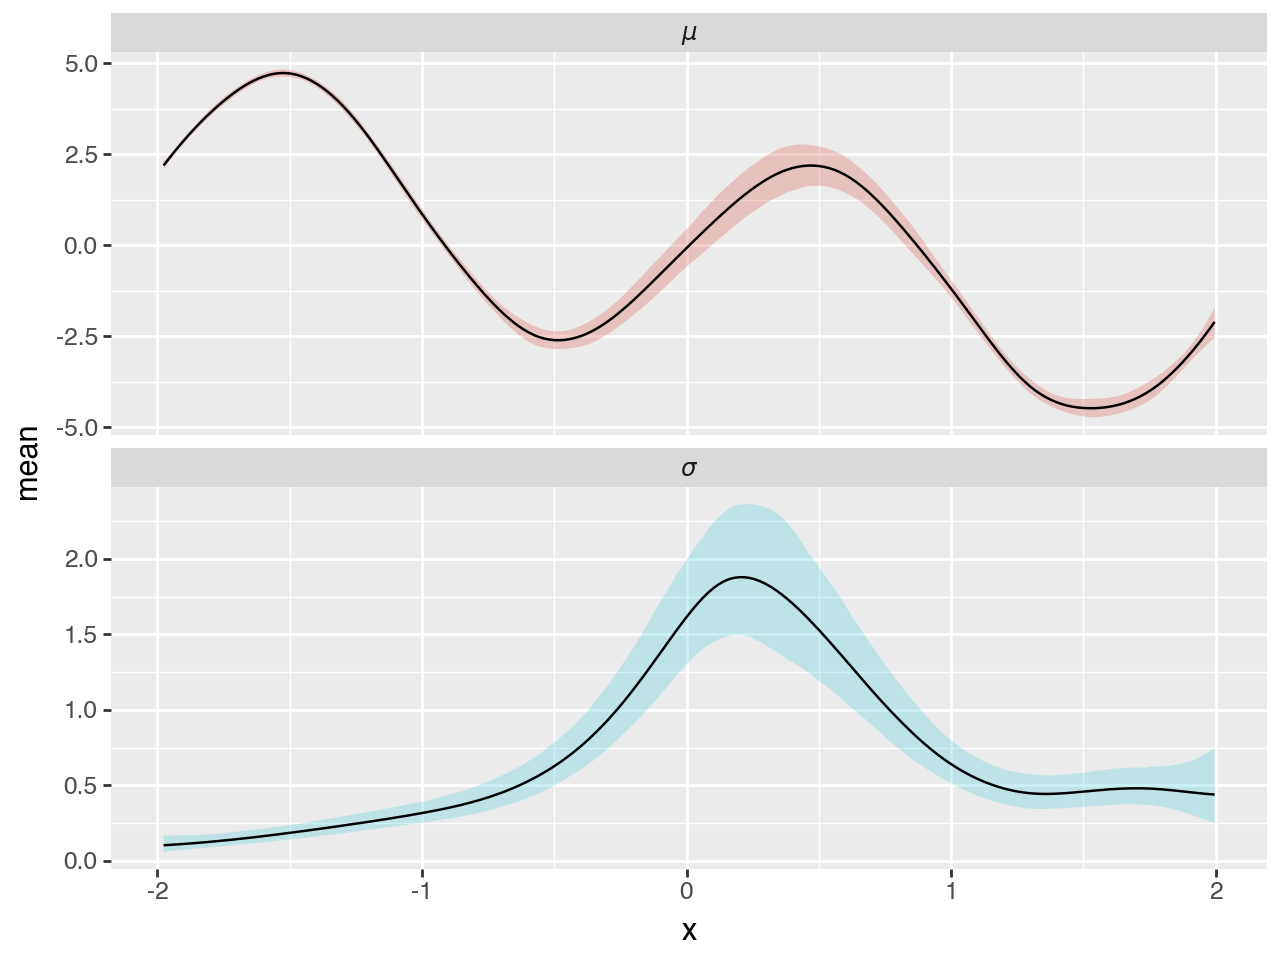

In [16]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

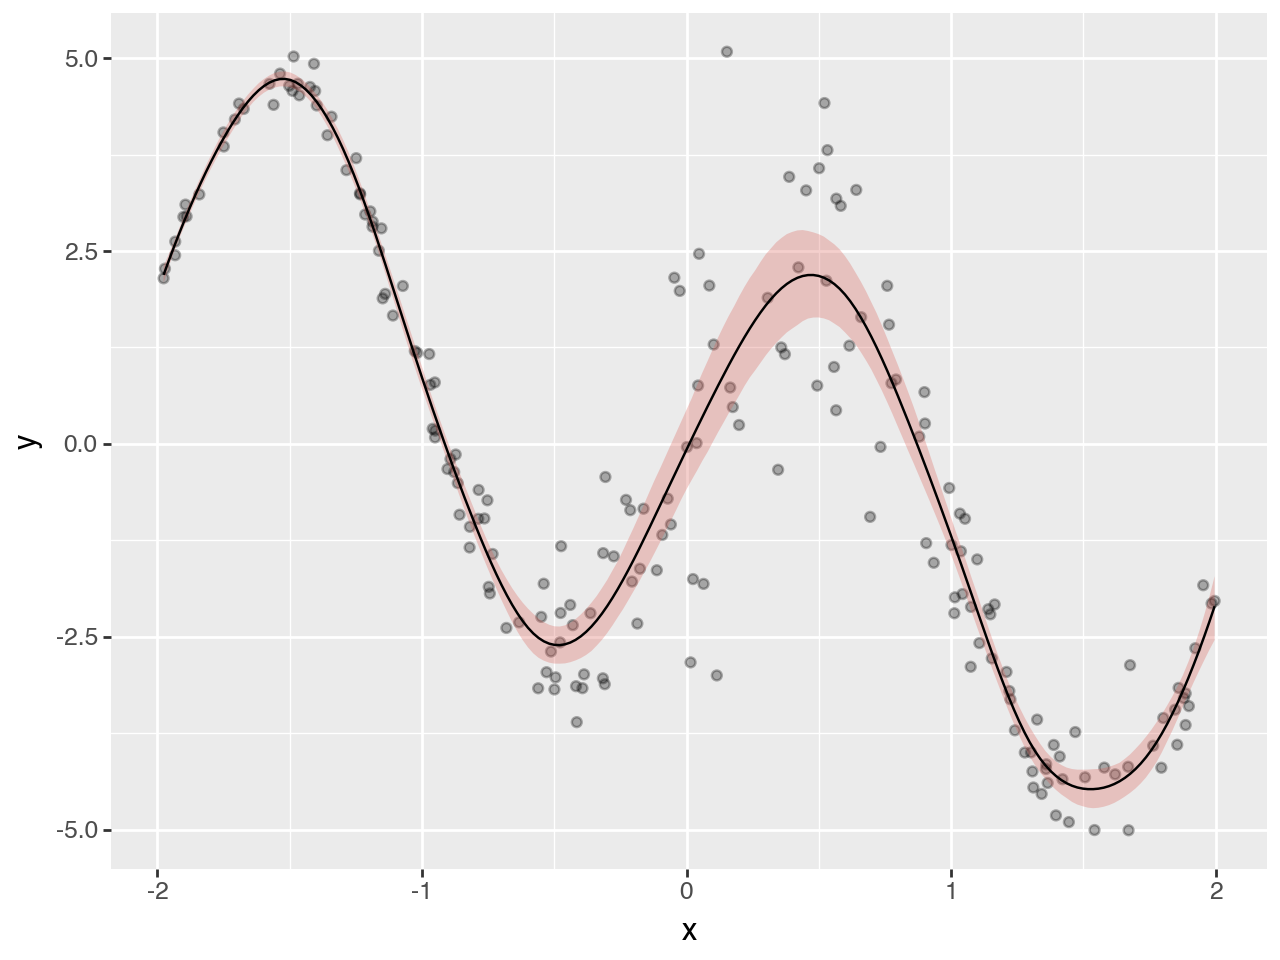

In [17]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [18]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.191582,0.103344,2.088238,2.294925
1,-1.956738,2.378958,0.105409,2.273549,2.484367
2,-1.936774,2.560425,0.107615,2.452811,2.668040
3,-1.916810,2.735928,0.109956,2.625972,2.845884
4,-1.896846,2.905407,0.112432,2.792975,3.017839
...,...,...,...,...,...
195,1.916248,-2.867191,0.451760,-3.318952,-2.415431
196,1.936212,-2.687942,0.448098,-3.136040,-2.239843
197,1.956176,-2.500678,0.444711,-2.945390,-2.055967
198,1.976140,-2.305768,0.441696,-2.747464,-1.864072


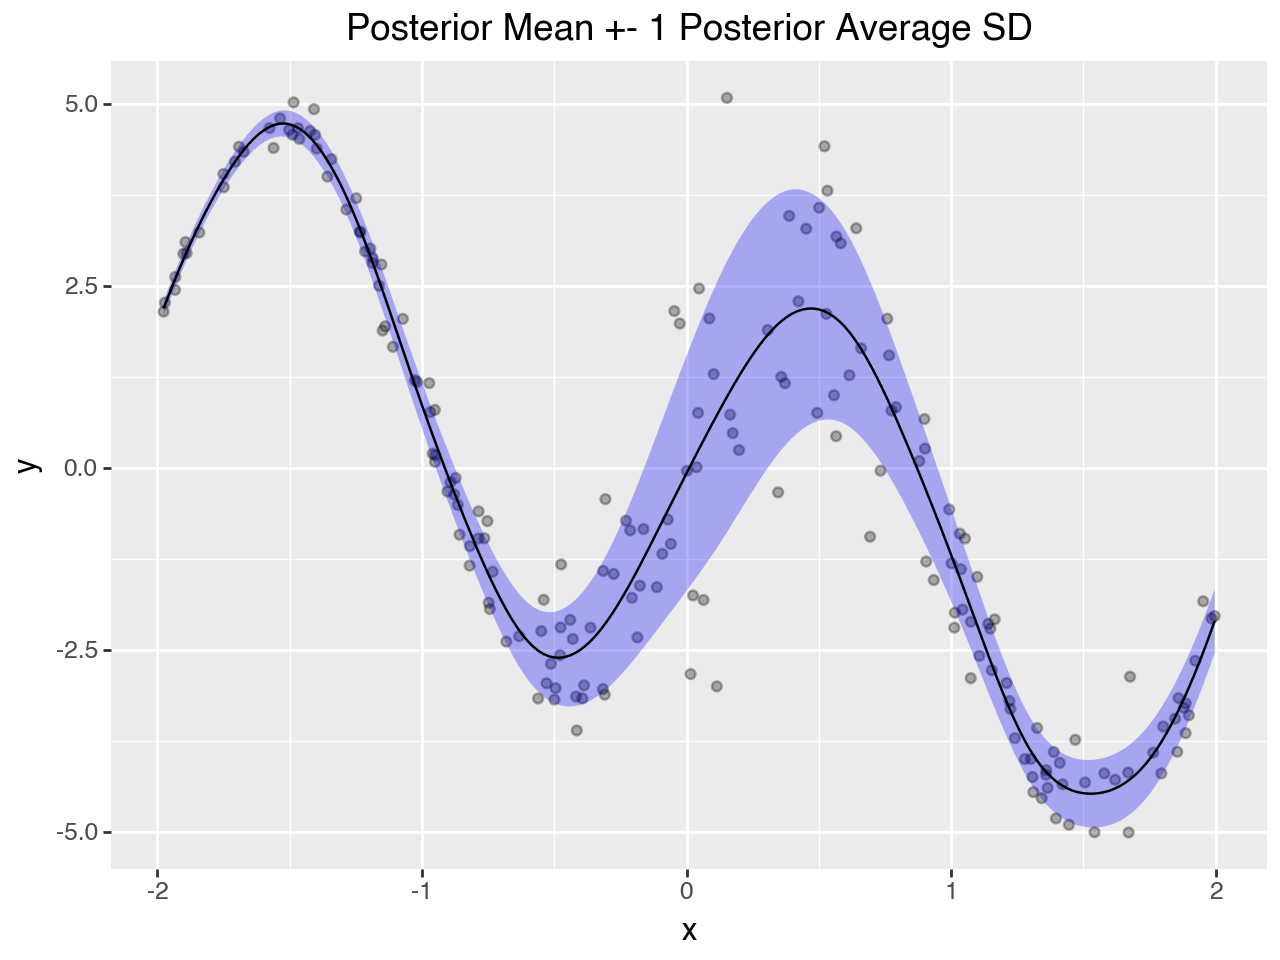

In [19]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [20]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [21]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [22]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

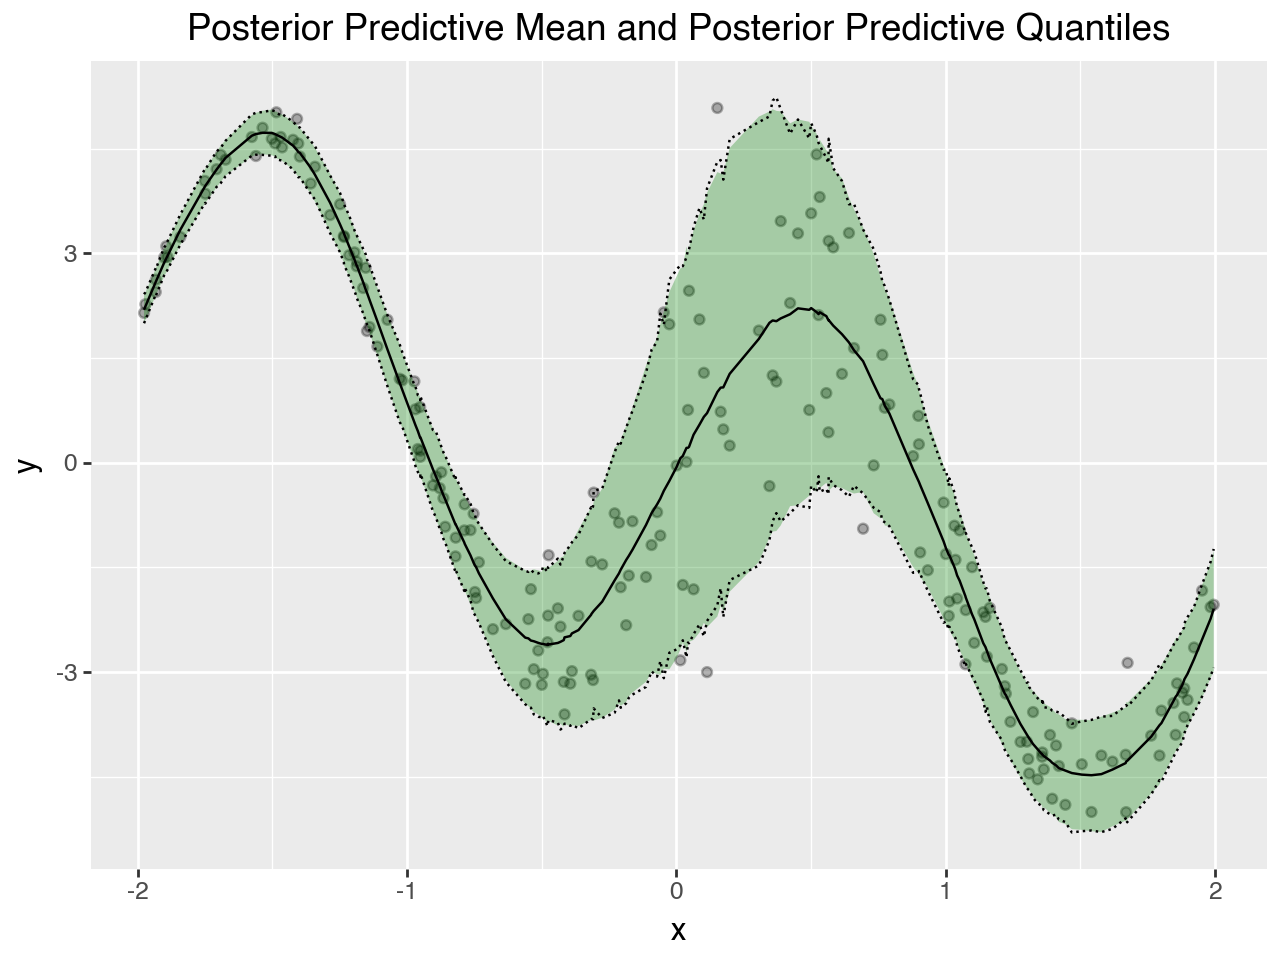

In [23]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

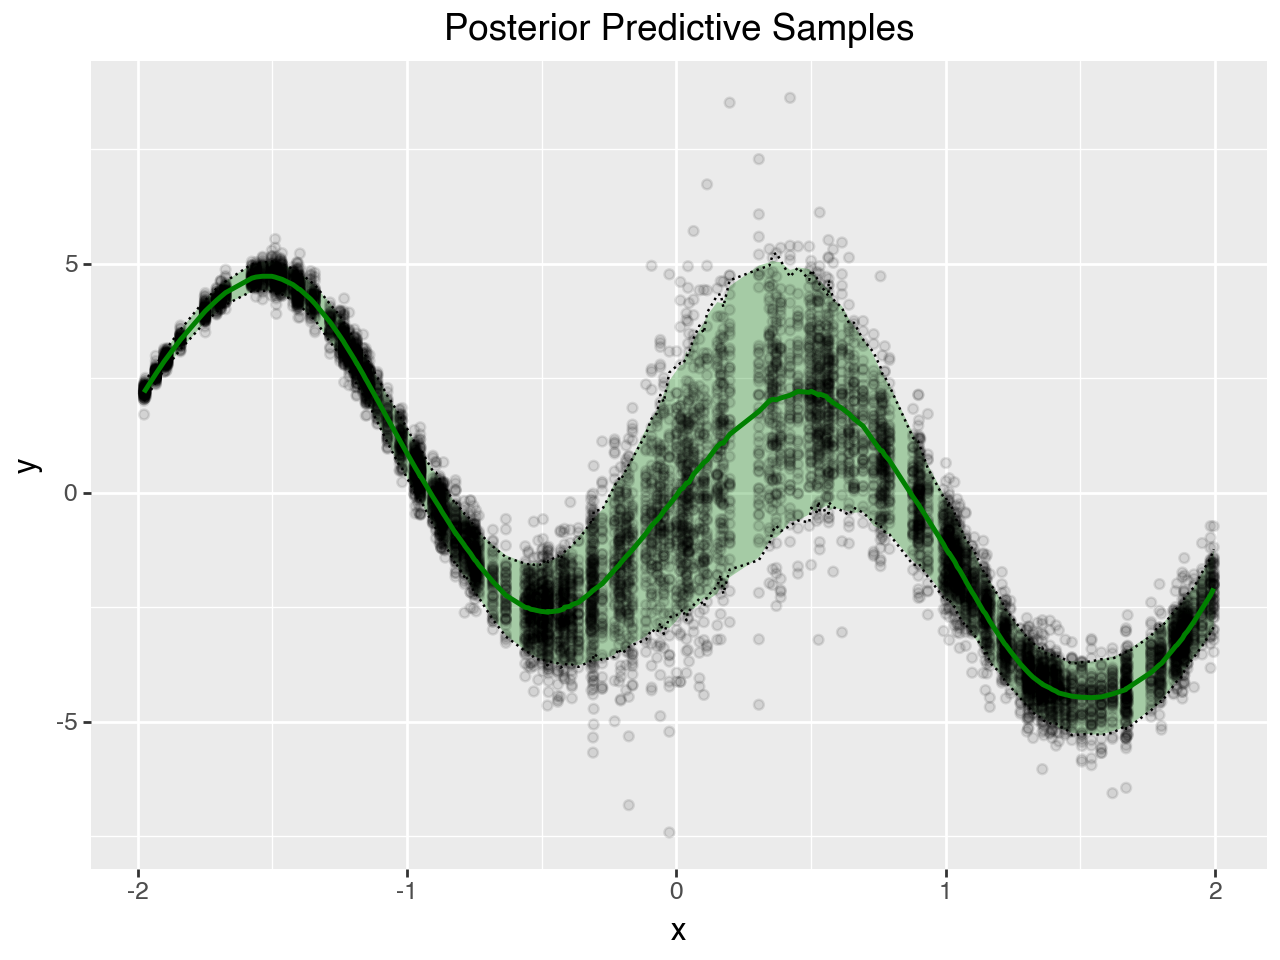

In [24]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)